# iSIM-sigma sampling

Notebook showing how iSIM-sigma is applicable to the calculation of the variance of the similarities of molecules chosen by different diversity selection methods. iSIM and iSIM-sigma values for the sampled molecules, can be compared to the values of the whole set to identify if the sampled molecules resemble the whole chemical space. 

In [10]:
import matplotlib.pyplot as plt
from isim_comp import calculate_isim
from isim_sigma import stratified_sigma
from isim_sampling import stratified_sampling, medoid_sampling, outlier_sampling, extremes_sampling, quota_sampling
from isim_utils import pairwise_average, npy_to_rdkit
import numpy as np
from rdkit import SimDivFilters
from sklearn.decomposition import PCA
import time
import pandas as pd

For this we are going to use the fingerprints for the natural products in the ChEMBL33 library

In [2]:
# Load the fingerprints 
fps = np.load('chembl_33_np.npy', mmap_mode='r')
print(fps.shape)

(64086, 2048)


### iSIM and iSIM-sigma values for the whole dataset

In [4]:
# Calculate the iSIM and stratified iSIM-sigma
isim = calculate_isim(fps, n_ary='JT')
isim_sigma = stratified_sigma(fps, 50, 'JT')

print(f'iSIM = {isim:.4f}')
print(f'iSIM-sigma = {isim_sigma:.4f}')

iSIM = 0.2745
iSIM-sigma = 0.1302


## iSIM and iSIM-sigma calculations for sampled molecules

We are going to sample molecules with: "medoid", "outlier", "extremes", "quota", "stratified", and "MaxMin" selection methods.

In [5]:
# Perform different samplings and calculate the iSIM-sigma for each of the picked molecules
times = {}
selected_molecules = {}
isims = {}
isim_sigmas = {}
pairwise_sigmas = {}
for sampling in [medoid_sampling, outlier_sampling, extremes_sampling, quota_sampling, stratified_sampling]:
    start = time.time()
    selected_fps = sampling(fps, percentage=10, n_ary = 'JT')
    end = time.time()
    selected_molecules[sampling.__name__] = selected_fps
    isims[sampling.__name__] = calculate_isim(fps[selected_fps], n_ary='JT')
    isim_sigmas[sampling.__name__] = stratified_sigma(fps[selected_fps], 50, 'JT')
    pairwise_sigmas[sampling.__name__]  = pairwise_average(fps[selected_fps], n_ary='JT')[1]
    times[sampling.__name__] = end - start

In [6]:
fps_rdkit = npy_to_rdkit(fps)
how_many_to_pick = int(0.1*len(fps))
mmp = SimDivFilters.MaxMinPicker()

import time

start = time.time()
picks = mmp.LazyBitVectorPick(fps_rdkit, len(fps_rdkit), how_many_to_pick)
end = time.time()
picks =[int(x) for x in picks]
print(f'Elapsed time: {end - start:.2f} s')

fps_sayle = fps[picks]
times['MaxMinPicker'] = end - start
isims['MaxMinPicker'] = calculate_isim(fps_sayle, n_ary='JT')
isim_sigmas['MaxMinPicker'] = stratified_sigma(fps_sayle, 50, 'JT')
pairwise_sigmas['MaxMinPicker'] = pairwise_average(fps_sayle, n_ary='JT')[1]
selected_molecules['MaxMinPicker'] = picks

Elapsed time: 15.86 s


### Results for iSIM and iSIM-sigma for the samples

We also include timing of the different sampling methods

In [7]:
# Render in a table the results of the dictionaries
df = pd.DataFrame({
    'iSIM': isims,
    'iSIM-sigma': isim_sigmas,
    'Pairwise sigma': pairwise_sigmas,
    'Time (s)': times
})

print(df)

                         iSIM  iSIM-sigma  Pairwise sigma   Time (s)
medoid_sampling      0.603107    0.074730        0.076290   2.106632
outlier_sampling     0.085576    0.068706        0.080735   2.108397
extremes_sampling    0.280086    0.274202        0.274794   2.088307
quota_sampling       0.311266    0.191267        0.188952   2.100005
stratified_sampling  0.274511    0.132884        0.130213   2.176306
MaxMinPicker         0.179139    0.093877        0.091677  15.858421


Perform a PCA to visualize the sampled molecules

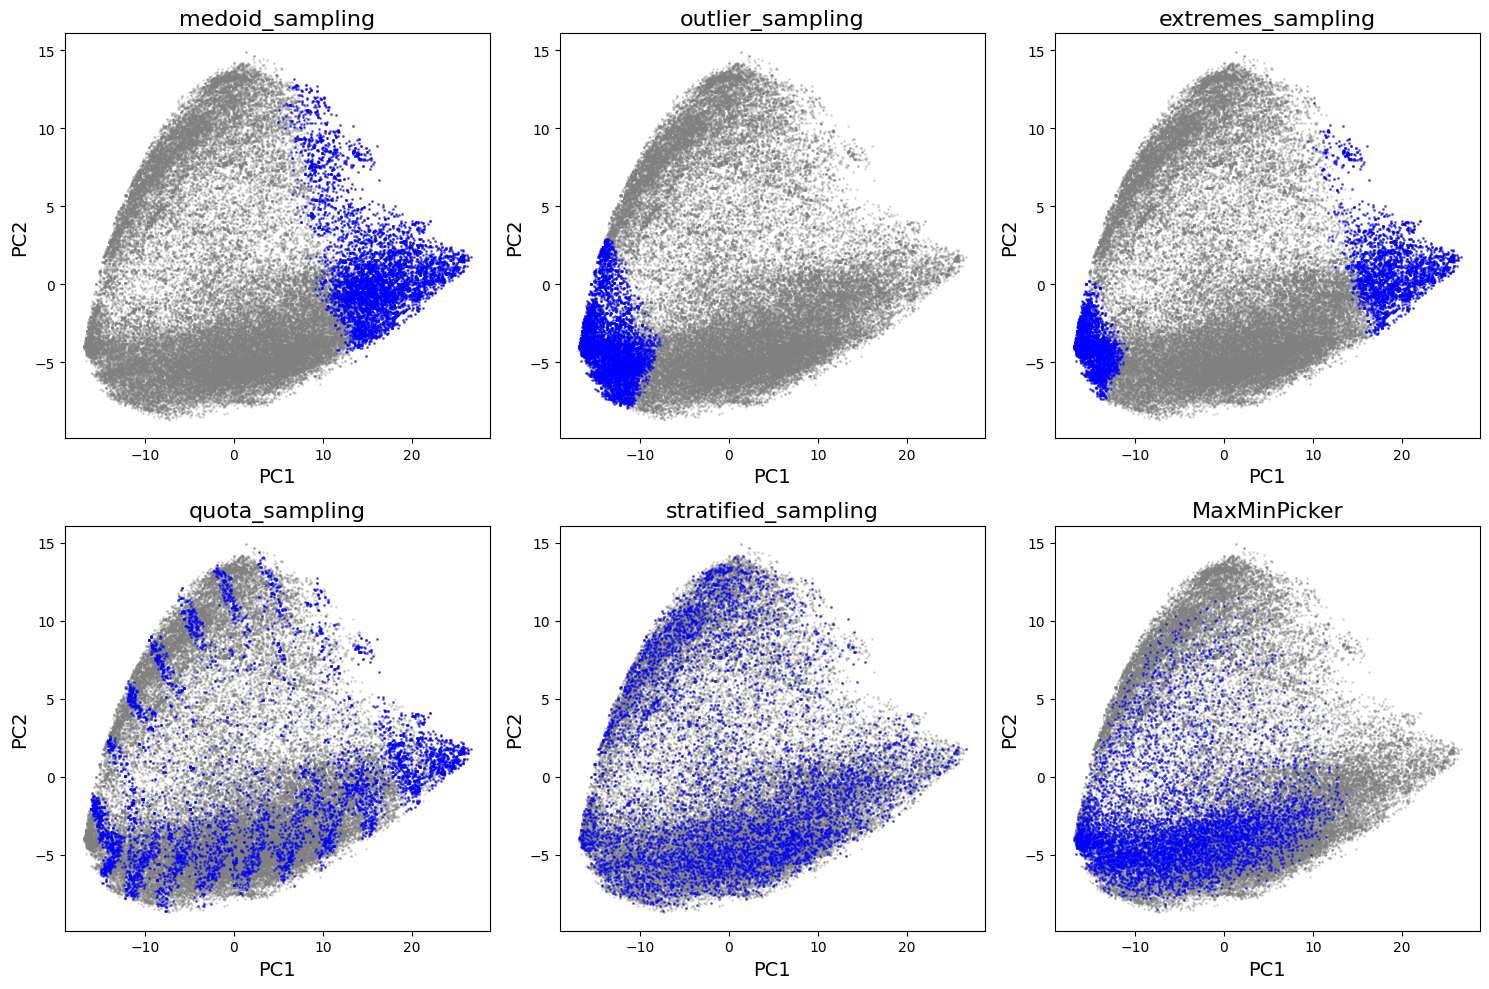

In [9]:
# Do a PCA of the molecules and color the selected one, usea a subplot for each sampling method
PCA_model = PCA(n_components=2)
fps_pca = PCA_model.fit_transform(fps)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, sampling in enumerate(selected_molecules.keys()):
    axs[i].scatter(fps_pca[:, 0], fps_pca[:, 1], alpha=0.25, color='gray', s=1)
    axs[i].scatter(fps_pca[selected_molecules[sampling], 0], fps_pca[selected_molecules[sampling], 1], alpha=0.5, color='blue', s=1)
    axs[i].set_title(sampling, fontsize=16)
    axs[i].set_xlabel('PC1', fontsize=14)
    axs[i].set_ylabel('PC2', fontsize=14)

plt.tight_layout()
plt.savefig('figures/sampling_pca.png')
plt.show()